# Прогнозирование отказа от брони

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [3]:
# тип номера отеля и цены за одну ночь и одну уборку
ROOM_CATEGORY_PRICE = {'A':(1000, 400), 'B':(800, 350), 'C':(600, 350),
                       'D':(550, 150), 'E':(500, 150), 'F':(450, 150), 
                       'G':(350, 150)}
# летняя сезонная наценка
SUMMER_PRICE = 1.4
# осенне-весенняя сезонная наценка
SPRING_PRICE = 1.2
# размер депозита
DEPOSIT = 0.8

### Открытие файлов с данными

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/' + 'hotel_train.csv')
data_test = pd.read_csv('https://code.s3.yandex.net/datasets/' + 'hotel_test.csv')

display(data.head())
display(data.info())
display(data_test.info())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

В таблицах `hotel_train` и `hotel_test` лежат данные о бронировании номеров: дата заказа, тип номера, тип клиента, количество постояльцев и много других. Всего признаков 25, записей в данных для обучения - 65229, в тестовых - 32412. Столбец `is_canceled` - целевой признак.

### Предобработка и исследовательский анализ данных

#### Предобработка

У столбцов `lead_time`, `adults`, `babies` и `children` тип float, хотя значения в них должны быть целыми. Может в `lead_time` записаны не целые дни?

In [5]:
lead = data['lead_time'] * 10 % 10
print(lead.unique())

[0.]


Нет, все значения целые. Меняем тип столбцов:

In [6]:
data['lead_time'], data_test['lead_time'] = data['lead_time'].astype('int'), data_test['lead_time'].astype('int')
data['adults'], data_test['adults'] = data['adults'].astype('int'), data_test['adults'].astype('int')
data['babies'], data_test['babies'] = data['babies'].astype('int'), data_test['babies'].astype('int')
data['children'], data_test['children'] = data['children'].astype('int'), data_test['children'].astype('int')

In [7]:
print(data['reserved_room_type'].unique())
print(data['meal'].unique())
print(data['distribution_channel'].unique())
print(data['customer_type'].unique())
print(data['arrival_date_month'].unique())
print(data['country'].unique())

data['reserved_room_type'], data_test['reserved_room_type'] = \
    data['reserved_room_type'].str.strip(), data_test['reserved_room_type'].str.strip()
data['meal'], data_test['meal'] = data['meal'].str.strip(), data_test['meal'].str.strip()

['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['Direct' 'TA/TO' 'Corporate' 'GDS']
['Transient' 'Contract' 'Transient-Party' 'Group']
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN'

В категориальных признаках в столбцах `reserved_room_type` и `meal` были лишние пробелы.

In [8]:
print('полные дубликаты:', data.duplicated().sum())
print('дубли id:', data['id'].duplicated().sum())

полные дубликаты: 0
дубли id: 0


Дубликатов в `hotel_train` нет.

In [10]:
display(data.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Описание данных показывает выбивающиеся значения в столбцах `lead_time`, `babies` `previous_bookings_not_canceled`, `previous_cancellations`, `booking_changes` и `days_in_waiting_list`.

(150.77599999999998, 173.3]    2742
(173.3, 195.6]                 2473
(195.6, 217.9]                 1813
(217.9, 240.2]                 1530
(240.2, 262.5]                 1455
(262.5, 284.8]                 1963
(284.8, 307.1]                 1700
(307.1, 329.4]                 1133
(329.4, 351.7]                 1079
(351.7, 374.0]                  494
Name: lead_time, dtype: int64


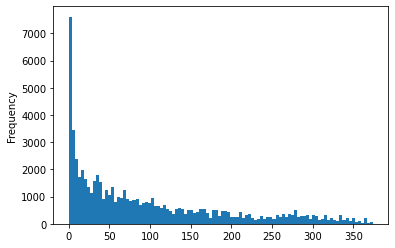

In [11]:
print(data[data['lead_time'] > 150]['lead_time'].value_counts(bins=10).sort_index())
data['lead_time'].plot(kind='hist', bins=100);

В столбце `lead_time` хранится количество дней между датой бронирования и датой прибытия клиента. Большинство клиентов занимают номер менее чем за сто дней, но и тех, кто планирует приезд на полгода-год вперед достаточно много - это не назовешь выбросом.

In [12]:
print(data['babies'].value_counts())
print(data['children'].value_counts())
print(data['adults'].value_counts())

print(round(data['adults'].value_counts()[0] / len(data) * 100, 2), '%')

0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64
0    61712
1     2165
2     1336
3       16
Name: children, dtype: int64
2    48980
1    13212
3     2858
0      166
4       13
Name: adults, dtype: int64
0.25 %


А в столбце `babies` уже точно выбросы - 10 младенцев на один номер это что-то. В столбцах `children` и `adults` также есть редкие значения. В столбце со взрослыми есть 166 записей о номерах с нулем взрослых - вероятно, это просто пропуски, ведь кто-то же должен был забронировать номер на себя? Эти пропуски можно было бы заполнить, например средним значением, но поскольку их мало (всего 0.25% от данных), думаю, их стоит удалить вместе с выбивающимися значениями.

In [13]:
print(data['previous_bookings_not_canceled'].value_counts(bins=10).sort_index())
print(data[data['previous_bookings_not_canceled'] == 1]['previous_bookings_not_canceled'].count())
print(data[data['previous_bookings_not_canceled'] > 1]['previous_bookings_not_canceled'].count())

print(data['previous_cancellations'].value_counts().sort_index())
print(data[data['previous_cancellations'] > 1]['previous_cancellations'].count())

(-0.059000000000000004, 5.8]    64922
(5.8, 11.6]                       175
(11.6, 17.4]                       49
(17.4, 23.2]                       32
(23.2, 29.0]                       21
(29.0, 34.8]                        5
(34.8, 40.6]                        6
(40.6, 46.4]                        6
(46.4, 52.2]                        7
(52.2, 58.0]                        6
Name: previous_bookings_not_canceled, dtype: int64
645
898
0     59591
1      5367
2        54
3        51
4         5
5        13
6         7
11       35
13       12
14       11
19       17
21        1
24       28
25       19
26       18
Name: previous_cancellations, dtype: int64
271


В столбцах с предыдущими отмененными и неотмененными бронями преобладает 0, есть 1. Остальных значений примерно одинаково мало, но всех вместе их, на самом деле, слишком много, чтобы просто удалить. Можно объединить эти значения в группы, например для столбца с отменами у клиентов в группе 0 нет отмен, в 1 - одна отмена, и в 2 - больше одной отмены. 

(60.801, 80.8]    482
(80.8, 100.6]     302
(100.6, 120.4]    178
(120.4, 140.2]     49
(140.2, 160.0]     63
(160.0, 179.8]    130
(179.8, 199.6]     46
(199.6, 219.4]     36
(219.4, 239.2]     45
(239.2, 259.0]     10
Name: days_in_waiting_list, dtype: int64
379 | 0.58 %


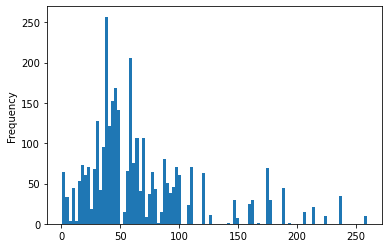

In [14]:
data[data['days_in_waiting_list'] > 0]['days_in_waiting_list'].plot(kind='hist', bins=100);
print(data[data['days_in_waiting_list'] > 60]['days_in_waiting_list'].value_counts(bins=10).sort_index())
print(data[data['days_in_waiting_list'] > 120]['days_in_waiting_list'].count(), '|', 
      round(data[data['days_in_waiting_list'] > 120]['days_in_waiting_list'].count() / len(data) * 100, 2), '%')

В столбце `days_in_waiting_list` - количество дней до подтверждения заказа. В основном заказы подтверждались в день поступления; за 4 месяца подтверждено более 99% заказов. Записи о заказах, подтвержденных более чем через 120 дней, придется удалить.

In [15]:
print(data['booking_changes'].value_counts())
print(data['total_of_special_requests'].value_counts().sort_index())
print(data['required_car_parking_spaces'].value_counts().sort_index())

0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64
0    40671
1    16958
2     6444
3     1036
4      107
5       13
Name: total_of_special_requests, dtype: int64
0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64


В `booking_changes` редко встречаются значения больше 4, в `total_of_special_requests` редко встречается 5, в `required_car_parking_spaces` - 2 и 3. Их тоже удалю.

In [16]:
prev = data.shape[0]

data = data[(data['adults'] != 0) & (data['adults'] != 4)].reset_index(drop=True)
data = data[data['children'] < 3].reset_index(drop=True)
data = data[data['babies'] < 2].reset_index(drop=True)

data.loc[data['previous_bookings_not_canceled'] > 1, 'previous_bookings_not_canceled'] = 2
data.loc[data['previous_cancellations'] > 1, 'previous_cancellations'] = 2
data = data[data['days_in_waiting_list'] < 120].reset_index(drop=True)
data = data[data['booking_changes'] < 5].reset_index(drop=True)
data = data[data['required_car_parking_spaces'] < 2].reset_index(drop=True)
data = data[data['total_of_special_requests'] < 5].reset_index(drop=True)

print(data.shape[0], '/', prev, '|', round(data.shape[0]/prev*100, 2))

64509 / 65229 | 98.9


Всего удалено 720 записей или 1.1% от данных.

In [17]:
print(data['arrival_date_month'].unique())
data['arrival_date_month'] = pd.to_datetime(data['arrival_date_year'].astype('str') + '/' + data['arrival_date_month'] + \
                                          '/' + data['arrival_date_day_of_month'].astype('str')).dt.month
data_test['arrival_date_month'] = pd.to_datetime(data_test['arrival_date_year'].astype('str') + '/' + data_test['arrival_date_month'] + \
                                          '/' + data_test['arrival_date_day_of_month'].astype('str')).dt.month
data['arrival_date_month'].unique()

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']


array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

В столбце с названием месяца придется заменить название на номер месяца для удобства анализа и обучения модели.

#### Исследование данных

Чтобы понять, какие клиенты склонны отменять бронирование, можно посмотреть, как процент отмены брони распределен в каждом признаке.

Признаков много, поэтому стоит написать функцию, которая делает сводную таблицу, считает процент отмен и выводит график:

In [18]:
def cancel_graphs(data, column, desc, figsize):
    table = data.pivot_table(index=column, values=['is_canceled'], aggfunc=['sum', 'count']).reset_index()
    ratio = table['sum', 'is_canceled'] / table['count', 'is_canceled'] * 100
    
    ax = plt.subplot()
    ratio.plot(kind='bar', figsize=figsize, alpha=0.5, grid=True);
    ax.set_xticklabels(data[column].sort_values().unique())
    plt.xlabel(desc)
    plt.ylabel('% отмены брони')
    plt.show()

In [19]:
print('Всего отмен:',
      round(data[data['is_canceled'] == 1]['is_canceled'].count() / data['is_canceled'].count() * 100, 2), '%')

Всего отмен: 36.9 %


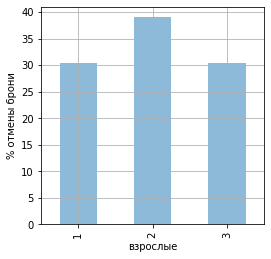

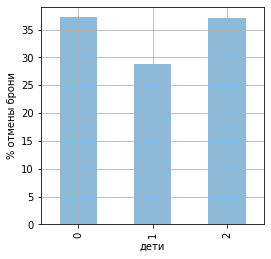

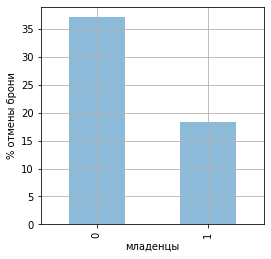

In [20]:
cancel_graphs(data, 'adults', 'взрослые', (4, 4))
cancel_graphs(data, 'children', 'дети', (4, 4))
cancel_graphs(data, 'babies', 'младенцы', (4, 4))

Для начала оценим процент отмен в разных возрастных категориях постояльцев.  
Среди взрослых самый большой процент отмен с двумя постояльцами - почти 40%. Заказы, где указаны 0 или 2 детей, отменяют примерно в 37% случаев, также как заказы, где 0 младенцев. Заказы, где указан 1 младенец отменяют реже всего - в менее 20% случаев. В целом разница в процентах не очень большая, и зависимостей от количества постояльцев не видно.

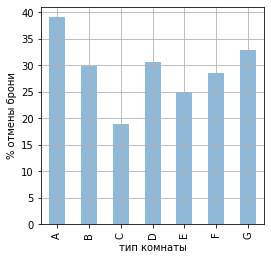

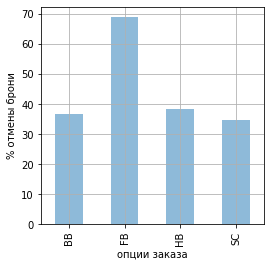

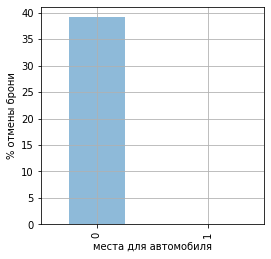

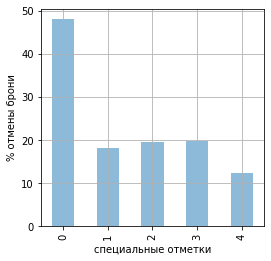

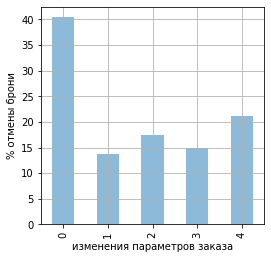

In [21]:
cancel_graphs(data, 'reserved_room_type', 'тип комнаты',  (4, 4))
cancel_graphs(data, 'meal', 'опции заказа', (4, 4))
cancel_graphs(data, 'required_car_parking_spaces', 'места для автомобиля', (4, 4))
cancel_graphs(data, 'total_of_special_requests', 'специальные отметки', (4, 4))
cancel_graphs(data, 'booking_changes', 'изменения параметров заказа', (4, 4))

Далее оценим процент отмен по параметрам заказа.  
Бронь номеров категории "А" отменяют чаще всего - примерно в 40% случаев, вторая по количеству отмен - категория "G" - 33% отмен. Меньше всего - около 18% - у категории "С". Зависимости от категории нет.  
Больше всего отмен у заказов, в которые включён завтрак, обед и ужин - почти 70%. У остальных опций около 35% отмен, что близко к общему проценту отмен.
Нет ни одной отмены у заказов, в которых клиенту было необходимо парковочное место.  
Заказы без специальных отметок отменяли в 48% случаев, от 1 до 3 отметок - в около 20% случаев, с 4 отметками - в 12%. Очевидно, если у клиента есть дополнительные пожелания, он спланировал поездку и не будет отменять заказ.  
Клиенты, не изменявшие параметры заказа, отменяли бронь в 40% случаев. Одно обдуманное изменение в заказе, и количество отмен падает до 14%. Похоже, что чем больше изменений в заказе, тем больше клиент не уверен в самом заказе и, возможно, отменит его. 

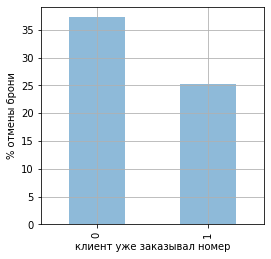

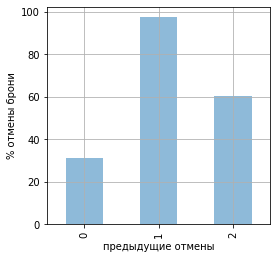

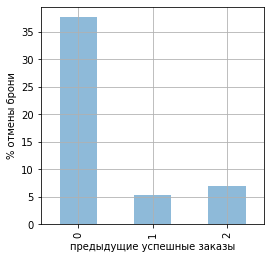

In [23]:
cancel_graphs(data, 'is_repeated_guest', 'клиент уже заказывал номер', (4, 4))
cancel_graphs(data, 'previous_cancellations', 'предыдущие отмены', (4, 4))
cancel_graphs(data, 'previous_bookings_not_canceled', 'предыдущие успешные заказы', (4, 4))

Процент отмен среди клиентов, заказывающих номер первый раз, близок к общим отменам - 37%. Зато те, кто уже был клиентом отеля, отменят заказ всего в 25% случаев.  
Те, кто отменил заказ один раз, также отменили следующий. У клиента было две или более отмены в 60% случаев. Те, кто ни разу не отменял бронь, отменили следующую в 30% случаев. В целом похоже, что те, кто уже отменял заказ, отменят следующий.  
Процент отмены среди тех, у кого еще не было неотмененных заказов, равен общим отменам. Те, у кого уже были успешные заказы, отменяют бронь всего в 5-7% случаев.

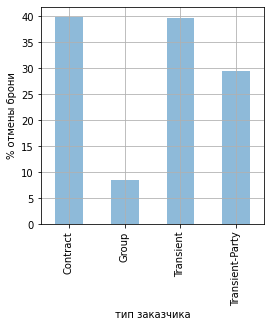

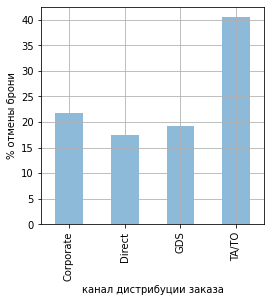

In [24]:
cancel_graphs(data, 'customer_type', 'тип заказчика', (4, 4))
cancel_graphs(data, 'distribution_channel', 'канал дистрибуции заказа', (4, 4))

В типе клиента и источнике заказа самые большие проценты отмены близки к общим отменам. Зависимостей здесь нет, единственное что сильно выделяется - групповые заезды отменили только в 8% случаев.

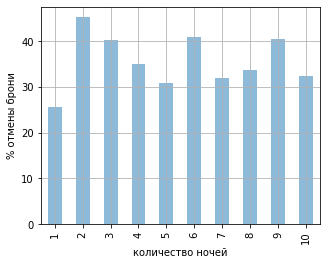

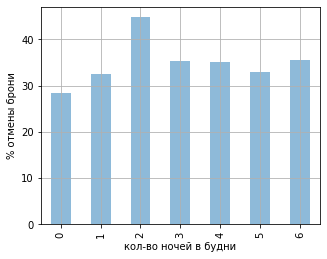

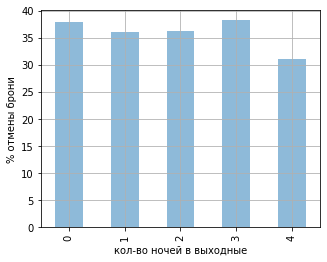

In [25]:
cancel_graphs(data, 'total_nights', 'количество ночей', (5, 4))
cancel_graphs(data, 'stays_in_week_nights', 'кол-во ночей в будни', (5, 4))
cancel_graphs(data, 'stays_in_weekend_nights', 'кол-во ночей в выходные', (5, 4))

С количеством ночей, которые клиент планирует остаться в номере, зависимости не видно. Процент отмен в основном близок к общему проценту отмен, выделяются 45% у двух ночей в целом и двух ночей в будние дни. Меньше всего клиентов отменили бронь, если им нужно было остаться всего на одну ночь.

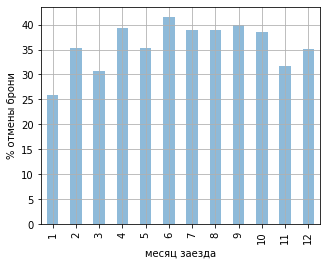

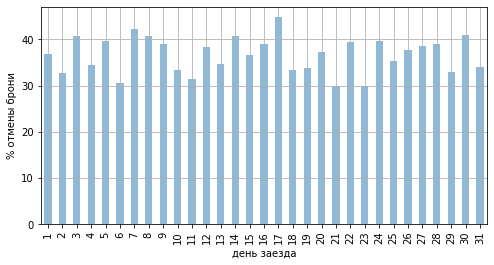

In [26]:
cancel_graphs(data, 'arrival_date_month', 'месяц заезда', (5, 4))
cancel_graphs(data, 'arrival_date_day_of_month', 'день заезда', (8, 4))

От времени заказа отмены зависят не сильно: в зимние месяцы отмен чуть меньше, чем в летние и осенние. День совсем не влияет на количество отмен. Больше всего отмен в июне, или 17 числа - около 43%, что не далеко от общих отмен.

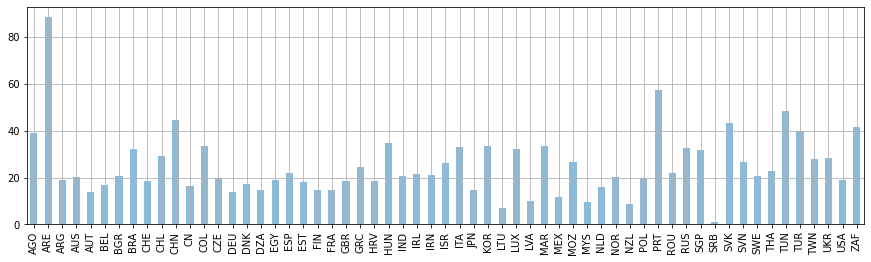

In [27]:
cancel_country = data.pivot_table(index=['country'], values=['is_canceled'], aggfunc=['sum', 'count']).reset_index()
cancel_country_ = cancel_country[cancel_country['count', 'is_canceled'] > 20]

cancel_country_ratio = cancel_country_['sum', 'is_canceled'] / cancel_country_['count', 'is_canceled'] * 100
ax = plt.subplot()
cancel_country_ratio.plot(kind='bar', figsize=(15, 4), alpha=0.5, grid=True);
ax.set_xticklabels(cancel_country_['country'].sort_values().unique())
plt.show()

И наконец распределение по гражданству постояльца. В каждом столбце на графике более 20 заказов.  
Почти 90% заказов от граждан ОАЭ были отменены. Португальцы вторые по отменам - ~58%, третьи граждане Туниса - ~48%. Граждане Сербии почти никогда не отменяют заказы, клиенты из Литвы и Новой Зеландии отменили всего 6-9% заказов. Клиенты из остальных стран в среднем отменили заказы в ~22% случаев.

Есть отдельные признаки надежных и ненадежных клиентов, например, если у клиента уже были успешные заказы, то он скорее всего не отменит следующий, или если в опциях заказа указано "FB", то скорее клиент отменит бронь. Зависимостей в признаках нет.

### Формулировка ML-задачи на основе бизнес-задачи

Далее для решения задачи нужно оценить прибыль отеля без внедрения депозитов.

Если клиент забронировал номер и успешно заселился, то прибыль отеля равна $$ стоимость\ номера * количество\ ночей * сезонный\ коэффициент - стоимость\ уборки * количество\ уборок  $$

В случае отмены брони убыток равен $$ стоимость\ номера * сезонный\ коэффициент + стоимость\ уборки  $$  
При внесении депозита в 80% отель теряет 20% от прибыли за одну ночь и затрат на одну уборку, т.е теряет
$$ (стоимость\ номера * сезонный\ коэффициент - стоимость\ уборки) * 20\% $$

Уборки проводятся каждые два дня: если клиент оставался на 1 или 2 ночи уборка одна, на 3 и 4 ночи - уборок две, и так далее.

Осталось собрать все формулы и написать функцию, которая будет считать прибыль для каждой из этих ситуаций:

In [29]:
def profit(client):
    total_nights, reserved_room_type, month, is_canceled, is_deposit = \
        client['total_nights'], client['reserved_room_type'], client['arrival_date_month'], \
        client['is_canceled'], client['is_deposit']
    season_price = 1
    profit = 0
    
    # считаем количество уборок
    cleanings = total_nights // 2 + total_nights % 2 
    
    # определяем сезонную наценку
    if (month == 12 or month == 1 or month == 2):
        season_price = 1
    elif (month == 6 or month == 7 or month == 8):
        season_price = SUMMER_PRICE
    else:
        season_price = SPRING_PRICE
        
    # если клиент отменяет бронь
    if is_canceled:
        # если клиент вносит депозит
        if is_deposit:
            profit = -1 * (ROOM_CATEGORY_PRICE[reserved_room_type][0] * season_price - 
                           ROOM_CATEGORY_PRICE[reserved_room_type][1]) * (1 - DEPOSIT)
        # если клиент не вносит депозит
        if not is_deposit:
            profit = -1 * (ROOM_CATEGORY_PRICE[reserved_room_type][0] * season_price + 
                           ROOM_CATEGORY_PRICE[reserved_room_type][1])
    # если клиент не отменяет бронь
    else:
        profit = ROOM_CATEGORY_PRICE[reserved_room_type][0] * total_nights * season_price - \
                ROOM_CATEGORY_PRICE[reserved_room_type][1] * cleanings
        
    return round(profit, 2)

Проверим функцию на примере: если клиент отменит бронь на номер категории "А" в июле:

In [30]:
print(data.loc[4, 'total_nights'], data.loc[4, 'reserved_room_type'],
      data.loc[4, 'arrival_date_month'], data.loc[4, 'is_canceled'])

test0 = data.join(pd.Series(0, name='is_deposit')).fillna(0).loc[4]
test1 = data.join(pd.Series(1, name='is_deposit')).fillna(1).loc[4]

print(profit(test0))
print(profit(test1))

3 A 7 1
-1800.0
-200.0


Без внесения депозита отель потеряет 1800 руб., а с депозитом всего 200.

Далее можно посчитать прибыль отеля за тестовый период без внедрения депозитов:

In [31]:
data_test['is_deposit'] = 0
profits_ = data_test.apply(profit, axis=1)
print(profits_.sum())

35300770.0


Прибыль составит 35.3 млн. Следующим шагом будет обучение модели, которая сможет увеличить прибыль более чем на 400 тыс..

### Разработка модели ML

Модель будет предсказывать отмену брони - это задача классификации. Для ее решения подойдет модель логистической регрессии, дерева решений или случайного леса. Но прежде чем обучать модели, нужно подготовить данные.

#### Подготовка

Столбцы с id и гражданством клиента и столбцы с датой не будут полезны для модели, отбрасываем их. Далее кодируем категориальные признаки: для обучения логистической регрессии признаки лучше кодировать техникой OHE, для дерева подойдет порядковое кодирование.

In [32]:
features = data.drop(['is_canceled','id','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month', 'country'],
                     axis=1)
target = data['is_canceled']

ordinal = ['meal', 'distribution_channel', 'reserved_room_type', 'customer_type']

features_tree = features
encoder = OrdinalEncoder(handle_unknown='ignore')
features_tree[ordinal] = pd.DataFrame(encoder.fit_transform(features_tree[ordinal]), columns=ordinal)

features_log = features
onecoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
onecoder.fit(features_log[ordinal])
features_log = pd.concat([features_log.drop(ordinal, axis=1),
                         pd.DataFrame(onecoder.transform(features_log[ordinal]))], axis=1)

display(features_tree.head(1), features_log.head(1))

,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,7,7,0,1,1,0,0,0.0,1.0,0,0,0,0.0,0,0,2.0,0,0,1


,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,9,10,11,12,13,14,15,16,17,18
0,7,7,0,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Масштабируем цифровые значения:

In [33]:
numeric = ['adults', 'babies', 'children', 'booking_changes', 'days_in_waiting_list', 'lead_time',
           'previous_bookings_not_canceled','previous_cancellations', 'required_car_parking_spaces',
          'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights', 'total_of_special_requests']
scaler = StandardScaler()
scaler.fit(features_log[numeric])

features_tree[numeric] = scaler.transform(features_tree[numeric])
features_log[numeric] = scaler.transform(features_log[numeric])
display(features_tree.head(1), features_log.head(1))

,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.924786,7,-0.967558,-0.899588,-1.783691,-0.219404,-0.083155,0.0,1.0,0,-0.302575,-0.14924,0.0,-0.352995,-0.189925,2.0,-0.245182,-0.683671,-1.175329


,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,9,10,11,12,13,14,15,16,17,18
0,-0.924786,7,-0.967558,-0.899588,-1.783691,-0.219404,-0.083155,0,-0.302575,-0.14924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Также по-разному кодируем тестовую выборку:

In [34]:
features_test = data_test.drop(['is_canceled','id','arrival_date_year','arrival_date_week_number',
                                'arrival_date_day_of_month', 'is_deposit', 'country'], axis=1)
target_test = data_test['is_canceled']

features_test_tree = features_test
features_test_tree[ordinal] = pd.DataFrame(encoder.transform(features_test_tree[ordinal]))
features_test_tree[numeric] = scaler.transform(features_test_tree[numeric])

features_test_log = pd.concat([features_test.drop(ordinal, axis=1),
                         pd.DataFrame(onecoder.transform(features_test[ordinal]))], axis=1)
features_test_log[numeric] = scaler.transform(features_test[numeric])

Данные подготовлены, можно приступать к обучению.

По задаче нужно минимизировать убытки, определив как можно больше отмен. Как метрику качества можно было бы использовать recall, но также нужно не забывать правильно определять клиентов, которые не отменят заказ, чтобы не нагружать их внесением депозита. Как метрика качества в этом случае лучше подойдет F1-мера.

Для более точной оценки качества модели проведем кросс-валидацию.

In [36]:
target.value_counts(normalize=1) 

0    0.630982
1    0.369018
Name: is_canceled, dtype: float64

В целевом признаке есть дисбаланс классов. Чтобы это исправить, можно применить, например, балансировку классов в модели или upsampling. Но поскольку мы проводим кросс-валидацию, нельзя сначала сделать upsampling - менять количество данных следует внутри кросс-валидации, на тренировочных фолдах.  
Напишу функцию, которая делит данные на фолды, балансирует тренировочные, обучает модель и считает F1-меру. На вход она получает модель для обучения, параметры для модели, и признаки; возращает среднюю для всех фолдов F1-меру.

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cross_val_score_model(model, params, class_weight, features, target, cv=kf): 
    scores = []
    for train_fold_index, val_fold_index in cv.split(features, target): # для каждого фолда:
        # назначаем фолды train и valid выборками
        features_train, target_train = features.iloc[train_fold_index], target.iloc[train_fold_index]
        features_valid, target_valid = features.iloc[val_fold_index], target.iloc[val_fold_index]
        
        # если баланс классов не class_weight
        if not class_weight == 'balanced':
            # то делаем upsample train фолда
            repeat = round(target_train.value_counts(normalize=1)[0] / target_train.value_counts(normalize=1)[1], 2)
                           
            features_zeros, features_ones = features_train[target_train == 0], features_train[target_train == 1]
            target_zeros, target_ones = target_train[target_train == 0], target_train[target_train == 1]
            
            features_train = pd.concat([features_zeros] + [features_ones.sample(frac=repeat, replace=True, random_state=1)])
            target_train = pd.concat([target_zeros] + [target_ones.sample(frac=repeat, replace=True, random_state=1)])
            features_train, target_train = shuffle(features_train, target_train, random_state=1)
            
        # обучаем модель, получаем f1 метрику 
        model_obj = model(**params).fit(features_train, target_train)
        score = f1_score(target_valid, model_obj.predict(features_valid))
        scores.append(score)
    # возращаем среднее метрик всех фолдов
    return pd.Series(scores).mean()

#### Логистическая регрессия

Начнем с логистической регрессии - создадим словарь гиперпараметров со списками значений. Для каждого значения гиперпараметра проведем кросс-валидацию и получим F1-меру. Из списка гиперпараметров выберем лучшие.

In [39]:
params_logreg = {'solver': ['liblinear'],
                 'C': [0.01,0.1,1,10,100],
                 'penalty': ['l1', 'l2'],
                 'random_state': [1],
                 'class_weight': [None, 'balanced']}

score_tracker = []
for C in tqdm(params_logreg['C']):
    for penalty in params_logreg['penalty']:
        for class_weight in params_logreg['class_weight']:
                params_ = {'solver': 'liblinear',
                             'C': C,
                             'penalty': penalty,
                             'class_weight': class_weight,
                             'random_state': 1}
                params_['f1'] = cross_val_score_model(LogisticRegression, params_, class_weight,
                                                      features_log, target, cv=kf)
                score_tracker.append(params_)

log_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(log_best)

100%|██████████| 5/5 [04:17<00:00, 51.52s/it]

{'solver': 'liblinear', 'C': 0.1, 'penalty': 'l2', 'class_weight': None, 'random_state': 1, 'f1': 0.6819304148159198}


Для логистической регрессии лучший результат F1-меры - 0.68.

#### Дерево решений

In [41]:
params_tree = {'max_depth': list(range(1, 11)),
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 4, 8],
               'random_state': [1],
               'class_weight': [None, 'balanced']}

score_tracker = []
for max_depth in tqdm(params_tree['max_depth']):
    for min_samples_leaf in params_tree['min_samples_leaf']:
        for min_samples_split in params_tree['min_samples_split']:
            for class_weight in params_tree['class_weight']:
                    params_ = {'max_depth': max_depth,
                               'min_samples_leaf': min_samples_leaf,
                               'min_samples_split': min_samples_split,
                               'class_weight': class_weight,
                               'random_state': 1}
                    params_['f1'] = cross_val_score_model(DecisionTreeClassifier, params_, class_weight,
                                                          features_tree, target, cv=kf)
                    score_tracker.append(params_)

tree_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(tree_best)

100%|██████████| 10/10 [01:27<00:00,  8.70s/it]

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'class_weight': 'balanced', 'random_state': 1, 'f1': 0.7323837142873557}


Лучшие гиперпараметры дерева решений дают F1-меру равную 0.732.

#### Случайный лес

In [42]:
params_forest = {'n_estimators': list(range(1, 22, 5)),
                 'max_depth': list(range(1, 11)), 
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 4, 8],
                 'random_state': [1],
                 'class_weight': [None, 'balanced']}
score_tracker = []
for trees in tqdm(params_forest['n_estimators']): # лесенка :D
    for depth in params_forest['max_depth']:
        for min_samples_leaf in params_forest['min_samples_leaf']:
            for min_samples_split in params_forest['min_samples_split']:
                for class_weight in params_forest['class_weight']:
                        params_ = {'n_estimators': trees,
                                   'max_depth': depth,
                                   'min_samples_leaf': min_samples_leaf,
                                   'min_samples_split': min_samples_split,
                                   'random_state': 1,
                                   'class_weight': class_weight}
                        params_['f1'] = cross_val_score_model(RandomForestClassifier, params_, class_weight,
                                                              features_tree, target, cv=kf)
                        score_tracker.append(params_)

forest_best = sorted(score_tracker, key=lambda x: x['f1'], reverse=True)[0]
print(forest_best)

100%|██████████| 5/5 [16:33<00:00, 198.79s/it]

{'n_estimators': 21, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 8, 'random_state': 1, 'class_weight': 'balanced', 'f1': 0.735312219723349}


Случайный лес с лучшими гипермараметрами показывает F1-меру равную 0.735, что чуть больше, чем у дерева.  
У этой модели самый лучший результат. Проверим ее на тестовой выборке.

#### Тест модели

{'n_estimators': 21, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 8, 'random_state': 1, 'class_weight': 'balanced'}
0.6358996171841769


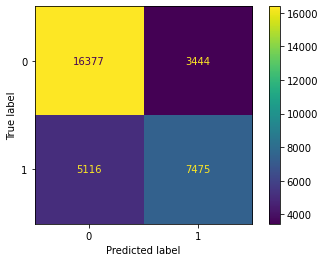

In [44]:
forest_best.pop('f1', forest_best)
print(forest_best)
fin_model = RandomForestClassifier(**forest_best)
fin_model.fit(features_tree, target)
pred = fin_model.predict(features_test_tree)
finscore = f1_score(target_test, pred)
print(finscore)
cm = confusion_matrix(target_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fin_model.classes_).plot();

Метрика качества на тестовой выборке упала до 0.635, видимо, модель все-таки переобучилась. Из всех предсказанных успешных заказов 24% оказались отменами, из предсказанных отмен 31.5% были успешными заказами. Правильно предсказанных отмен - 60%, успешных заказов - 83%. 
Посчитаем прибыль, которую принесет эта модель.

#### Оценка прибыльности модели

In [45]:
data_test['is_deposit'] = pred
profits_pred = data_test.apply(profit, axis=1)

data_test['is_deposit'] = target_test
profits100 = data_test.apply(profit, axis=1)
    
profits_ = pd.Series(profits_).sum()
profits_pred = pd.Series(profits_pred).sum()
profits100 = pd.Series(profits100).sum()

print(profits_, '|', (profits_-profits_)/(profits100-profits_)*100, '%')
print(profits_pred, '|', round((profits_pred-profits_)/(profits100-profits_)*100, 2), '%')
print(profits100, '|', (profits100-profits_)/(profits100-profits_)*100, '%')

print((profits_pred-profits_), '/', (profits100-profits_), '|', 
      round((profits_pred-profits_)/(profits100-profits_)*100, 2), '%')

35300770.0 | 0.0 %
45053390.0 | 60.4 %
51448738.0 | 100.0 %
9752620.0 / 16147968.0 | 60.4 %


За тестовый период прибыль без внесения депозитов была равна 35.3 млн.. Если бы предсказания модели были 100% верны, то прибыль с депозитами составила бы 51.4 млн.. Выбранная модель принесла бы 45 млн., что составляет 60.4% от потенциально возможной прибыли. Прирост прибыли - 9.75 млн из возможных 16.1 млн.. Если учесть затраты на разработку системы в 400 тыс., то чистая прибыль за тестовый период будет 9.35 млн..

### Портрет «ненадёжного» клиента

На основе исследовательского анализа данных можно сказать, что у «ненадёжного» клиента нет четкого портрета.  
Клиент склонен к отмене брони, если:
- указывает в опциях заказа "FB",
- уже отменял хотя бы одну бронь,
- не оставляет специальных отметок к заказу,
- клиент - гражданин ОАЭ, Португалии или Туниса.  

И наоборот, клиент скорее не будет отменять заказ, если:
- оставляет несколько специальных отметок к заказу,
- у клиента уже были успешные заказы,
- клиенту необходимо парковочное место,
- заказ на групповой заезд,
- заказан номер категории "С",
- клиент - гражданин Сербии, Литвы или Новой Зеландии.

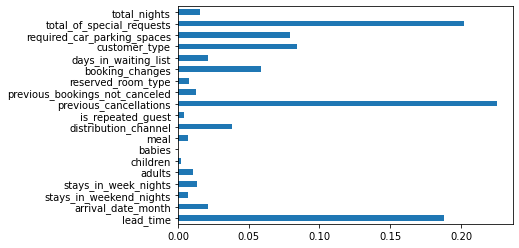

In [46]:
pd.Series(fin_model.feature_importances_, index=features_tree.columns).plot(kind='barh');

Модель также считает, что на отмену брони влияют предыдущие отмены, тип клиента, количество отметок, изменений в заказе и парковочные места.

### Общий вывод

Лучшая модель для решения этой и в целом любой задачи, очевидно та, что сделает более точные предсказания. В данном случае не думаю, что получится сильно увеличить точность - у клиентов, отменяющих бронь, нет ярко выраженных признаков, и модель не может эффективно их определять. Может, если добавить новой информации о клиентах или собрать данные за больший период, модель сможет найти взаимосвязи в них. *Сейчас лучший результат, которого удалось достичь - 60% правильно предсказанных отмен и 83% правильно предсказанных успешных заказов. Модель - случайный лес с 21 деревом и их глубиной 10, c min_samples_split равными 8 и взвешенными классами.* Модель показала чистую прибыль в 9.35 млн., что превышает затраты на разработку во много раз.

Для решения задачи была проделана следующая работа:
- предобработаны данные: удалены выбивающиеся значения, сменен тип данных у признаков;
- проведено исследование данных;
- написана функция расчета прибыли;
- написана функция кросс-валидации;
- обучены несколько моделей, оценено их качество кросс-валидацией;
- протестирована лучшая модель;
- посчитана прибыль лучшей модели.